In [129]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import operator
%matplotlib inline

In [130]:
datapath = "../data_preprocessed_01/all_matches_csv.csv"
data = pd.read_csv(datapath)

In [131]:
data['overs'] = data['overs'] + 1

In [132]:
temp_data = data
temp_data.head()

,match_id,ball,innings,over_and_ball,batting_team_name,batsman,non_striker,bowler,runs_off_bat,extras,...,runs_scored,wickets_fallen,balls_bowled,req_run_rate,target_score,innings_total_runs,fielding_team,runs_remaining,wickets_in_hand,run_rate
0,65239,ball,1,0.1,Canada,I Maraj,JM Davison,Manjural Islam,4,0,...,4,0,1,NaN,NaN,180,Bangladesh,176,10,24.0
1,65239,ball,1,0.2,Canada,I Maraj,JM Davison,Manjural Islam,0,0,...,4,0,2,NaN,NaN,180,Bangladesh,176,10,12.0
2,65239,ball,1,0.3,Canada,I Maraj,JM Davison,Manjural Islam,0,1,...,5,0,2,NaN,NaN,180,Bangladesh,175,10,15.0
3,65239,ball,1,0.4,Canada,I Maraj,JM Davison,Manjural Islam,0,0,...,5,0,3,NaN,NaN,180,Bangladesh,175,10,10.0
4,65239,ball,1,0.5,Canada,I Maraj,JM Davison,Manjural Islam,0,0,...,5,0,4,NaN,NaN,180,Bangladesh,175,10,7.5


In [133]:
col_batting_team = temp_data.groupby(['match_id','innings','fielding_team'])['batting_team_name']
col_fielding_team = temp_data.groupby(['match_id','innings','batting_team_name'])['fielding_team']
col_winner = temp_data.groupby(['match_id','innings','batting_team_name','fielding_team','match_winner'])['match_winner']


In [134]:
type(col_fielding_team)

pandas.core.groupby.generic.SeriesGroupBy

In [135]:
col_fielding_team =pd.DataFrame(col_fielding_team)
col_fielding_team.head()

,0,1
0,"(64814, 1, New Zealand)",787017 India 787018 India 787019 Indi...
1,"(64814, 2, India)",787326 New Zealand 787327 New Zealand 78...
2,"(64815, 1, India)",361652 New Zealand 361653 New Zealand 36...
3,"(64815, 2, New Zealand)",361913 India 361914 India 361915 Indi...
4,"(64816, 1, India)",696247 New Zealand 696248 New Zealand 69...


In [136]:
type(col_fielding_team)

pandas.core.frame.DataFrame

In [137]:
col_batting_team = pd.DataFrame(col_batting_team)
col_batting_team.tail()


,0,1
4711,"(1390346, 2, Pakistan)",776745 Afghanistan 776746 Afghanistan 77...
4712,"(1395701, 1, Bangladesh)",497356 New Zealand 497357 New Zealand 49...
4713,"(1395701, 2, New Zealand)",497659 Bangladesh 497660 Bangladesh 4976...
4714,"(1395702, 1, New Zealand)",365541 Bangladesh 365542 Bangladesh 3655...
4715,"(1395702, 2, Bangladesh)",365754 New Zealand 365755 New Zealand 36...


In [138]:
col_winner =pd.DataFrame(col_winner)

col_winner['list_col'] = col_winner[0].apply(lambda x:list(x))
col_winner = col_winner.drop(columns=[0,1])
col_winner['match_id'] = col_winner['list_col'].apply(lambda x:x[0])
col_winner['inning'] = col_winner['list_col'].apply(lambda x: x[1])
col_winner['winner'] = col_winner['list_col'].apply(lambda x:x[-1])
col_winner = col_winner.drop(columns=['list_col'])
col_winner.head()

,match_id,inning,winner
0,64814,1,New Zealand
1,64814,2,New Zealand
2,64815,1,New Zealand
3,64815,2,New Zealand
4,64816,1,New Zealand


In [139]:
col_batting_team['list_col'] = col_batting_team[0].apply(lambda x: list(x))
col_fielding_team['list_col'] = col_fielding_team[0].apply(lambda x:list(x))


In [140]:
col_batting_team = col_batting_team.drop(columns=[0,1])
col_fielding_team = col_fielding_team.drop(columns=[0,1])

In [141]:
col_batting_team['match_id'] = col_batting_team['list_col'].apply(lambda x: x[0])
col_batting_team['inning'] = col_batting_team['list_col'].apply(lambda x: x[1])
col_batting_team['batting_team'] = col_batting_team['list_col'].apply(lambda x: x[2])

In [142]:
col_batting_team = col_batting_team.drop(columns=['list_col'])
col_batting_team

,match_id,inning,batting_team
0,64814,1,India
1,64814,2,New Zealand
2,64815,1,New Zealand
3,64815,2,India
4,64816,1,New Zealand
...,...,...,...
4711,1390346,2,Pakistan
4712,1395701,1,Bangladesh
4713,1395701,2,New Zealand
4714,1395702,1,New Zealand


In [143]:
col_fielding_team['match_id'] = col_fielding_team['list_col'].apply(lambda x: x[0])
col_fielding_team['inning'] = col_fielding_team['list_col'].apply(lambda x: x[1])
col_fielding_team['fielding_team'] = col_fielding_team['list_col'].apply(lambda x: x[2])

col_fielding_team = col_fielding_team.drop(columns=['list_col'])
col_fielding_team

,match_id,inning,fielding_team
0,64814,1,New Zealand
1,64814,2,India
2,64815,1,India
3,64815,2,New Zealand
4,64816,1,India
...,...,...,...
4711,1390346,2,Afghanistan
4712,1395701,1,New Zealand
4713,1395701,2,Bangladesh
4714,1395702,1,Bangladesh


In [144]:
type(col_fielding_team)

pandas.core.frame.DataFrame

In [145]:
wickets_in_over = temp_data.groupby(['match_id','innings','overs'])['wicket_ball'].sum().unstack(fill_value=0)

In [146]:
wickets_in_over = pd.DataFrame(wickets_in_over)
wickets_in_over = wickets_in_over.to_numpy()
wickets_in_over = wickets_in_over.tolist()

In [147]:
col_list = ['over_and_ball', 'batsman',
            'non_striker', 'bowler', 'runs_off_bat', 'extras', 'wides', 'no_balls', 'byes', 'leg_byes', 'penalty', 'kind_of_wicket', 'dismissed_player', 'valid_ball','wicket_ball','date','runs_scored','wickets_fallen','balls_bowled',]
temp_data = temp_data.drop(col_list,axis=1)

In [148]:
temp_data.head()

,match_id,ball,innings,batting_team_name,runs_on_this_ball,overs,toss_winner,match_winner,toss_winner_chose_bat_first,match_country,req_run_rate,target_score,innings_total_runs,fielding_team,runs_remaining,wickets_in_hand,run_rate
0,65239,ball,1,Canada,4,1,Canada,Canada,True,South Africa,NaN,NaN,180,Bangladesh,176,10,24.0
1,65239,ball,1,Canada,0,1,Canada,Canada,True,South Africa,NaN,NaN,180,Bangladesh,176,10,12.0
2,65239,ball,1,Canada,1,1,Canada,Canada,True,South Africa,NaN,NaN,180,Bangladesh,175,10,15.0
3,65239,ball,1,Canada,0,1,Canada,Canada,True,South Africa,NaN,NaN,180,Bangladesh,175,10,10.0
4,65239,ball,1,Canada,0,1,Canada,Canada,True,South Africa,NaN,NaN,180,Bangladesh,175,10,7.5


In [149]:
temp_copy = temp_data.copy()
temp_data = temp_copy.fillna(-1.0,inplace=True)

In [150]:


temp_copy.head()

,match_id,ball,innings,batting_team_name,runs_on_this_ball,overs,toss_winner,match_winner,toss_winner_chose_bat_first,match_country,req_run_rate,target_score,innings_total_runs,fielding_team,runs_remaining,wickets_in_hand,run_rate
0,65239,ball,1,Canada,4,1,Canada,Canada,True,South Africa,-1.0,-1.0,180,Bangladesh,176,10,24.0
1,65239,ball,1,Canada,0,1,Canada,Canada,True,South Africa,-1.0,-1.0,180,Bangladesh,176,10,12.0
2,65239,ball,1,Canada,1,1,Canada,Canada,True,South Africa,-1.0,-1.0,180,Bangladesh,175,10,15.0
3,65239,ball,1,Canada,0,1,Canada,Canada,True,South Africa,-1.0,-1.0,180,Bangladesh,175,10,10.0
4,65239,ball,1,Canada,0,1,Canada,Canada,True,South Africa,-1.0,-1.0,180,Bangladesh,175,10,7.5


In [151]:
col_l = ['innings_total_runs','runs_remaining','run_rate']
temp = temp_copy

temp = temp.drop(col_l,axis=1)

In [152]:
temp.head()
temp_copy = temp


In [153]:
temp_copy.head()

,match_id,ball,innings,batting_team_name,runs_on_this_ball,overs,toss_winner,match_winner,toss_winner_chose_bat_first,match_country,req_run_rate,target_score,fielding_team,wickets_in_hand
0,65239,ball,1,Canada,4,1,Canada,Canada,True,South Africa,-1.0,-1.0,Bangladesh,10
1,65239,ball,1,Canada,0,1,Canada,Canada,True,South Africa,-1.0,-1.0,Bangladesh,10
2,65239,ball,1,Canada,1,1,Canada,Canada,True,South Africa,-1.0,-1.0,Bangladesh,10
3,65239,ball,1,Canada,0,1,Canada,Canada,True,South Africa,-1.0,-1.0,Bangladesh,10
4,65239,ball,1,Canada,0,1,Canada,Canada,True,South Africa,-1.0,-1.0,Bangladesh,10


In [154]:
col = ['ball']
temp = temp.drop(col,axis=1)


In [155]:
temp.head()
match_ids = temp['match_id']
match_ids = set(match_ids)
print(len(match_ids))

2358


In [156]:
runs = temp.groupby(['match_id','innings', 'overs'])['runs_on_this_ball'].sum().unstack(fill_value=0)

In [157]:
# col = ['match_id','innings']
# runs = runs.drop(col,axis=1)
# runs = pd.DataFrame(runs)
runs = runs.to_numpy()
runs = runs.tolist()
match_ids = temp.groupby(['match_id'])

In [158]:
match_ids = pd.DataFrame(match_ids)
match_ids
match_ids = match_ids.drop(columns=[1],axis=1)

In [159]:
match_ids

,0
0,"(64814,)"
1,"(64815,)"
2,"(64816,)"
3,"(64817,)"
4,"(64819,)"
...,...
2353,"(1390344,)"
2354,"(1390345,)"
2355,"(1390346,)"
2356,"(1395701,)"


In [160]:
wickets_in_hands = temp.groupby(['match_id','innings','overs'])['wickets_in_hand'].max().unstack(fill_value=0)
wickets_in_hands = wickets_in_hands.to_numpy()
wickets_in_hands = wickets_in_hands.tolist()

In [161]:
match_ids_list = []
for ele in match_ids[0]:
    id = list(ele)
    match_ids_list.append(id)

In [162]:
match_ids_list = np.array(match_ids_list)

In [163]:
match_ids_list

array([[  64814],
       [  64815],
       [  64816],
       ...,
       [1390346],
       [1395701],
       [1395702]])

In [164]:
match_ids_list = match_ids_list.reshape(-1)
match_ids_list

array([  64814,   64815,   64816, ..., 1390346, 1395701, 1395702])

In [165]:
list_match_ids = match_ids_list.tolist()

In [166]:
list_match_ids

[64814,
 64815,
 64816,
 64817,
 64819,
 64820,
 64825,
 64826,
 64827,
 64829,
 64830,
 64831,
 64832,
 64833,
 64836,
 64837,
 64838,
 64839,
 64840,
 64841,
 64842,
 64843,
 64844,
 64845,
 64846,
 64848,
 64849,
 64850,
 64851,
 64852,
 64853,
 64855,
 64857,
 64862,
 64864,
 64865,
 64870,
 64871,
 64872,
 64874,
 64881,
 64882,
 64883,
 64884,
 64885,
 64887,
 64891,
 64894,
 64896,
 64897,
 64898,
 64899,
 64900,
 64901,
 64905,
 64906,
 64907,
 64910,
 64911,
 64913,
 64914,
 64917,
 64919,
 64922,
 64923,
 64924,
 64925,
 64926,
 64927,
 64928,
 64929,
 64932,
 64933,
 64934,
 64935,
 64936,
 64939,
 64941,
 64942,
 64943,
 65029,
 65030,
 65031,
 65032,
 65033,
 65034,
 65235,
 65236,
 65237,
 65238,
 65239,
 65240,
 65241,
 65242,
 65244,
 65245,
 65246,
 65247,
 65248,
 65249,
 65250,
 65251,
 65252,
 65254,
 65255,
 65256,
 65257,
 65258,
 65259,
 65260,
 65261,
 65262,
 65263,
 65264,
 65265,
 65266,
 65267,
 65268,
 65269,
 65270,
 65271,
 65272,
 65275,
 65276,
 65277,


In [167]:
counts = Counter(list_match_ids)

col_match_ids = []
for number, count in counts.items():
    col_match_ids.extend([number] * 100)

In [168]:
len(col_match_ids)

235800

In [169]:
col_wickets_in_hands = []
col_runs_scored_in_over = []
col_wickets_in_over =[]

for i in range(len(wickets_in_hands)):
    for j in range(len(wickets_in_hands[0])):
        col_runs_scored_in_over.append(runs[i][j])
        col_wickets_in_hands.append(wickets_in_hands[i][j])
        col_wickets_in_over.append(wickets_in_over[i][j])

In [170]:
len(col_runs_scored_in_over)

235800

In [171]:
len(col_wickets_in_hands)

235800

In [172]:
col_innings = np.empty(235800)

for i in range(0, 235800, 100):
    col_innings[i:i+50] = 1
    col_innings[i+50:i+100] = 2

In [173]:
col_innings

array([1., 1., 1., ..., 2., 2., 2.])

In [174]:

array = np.arange(1, 51)
col_overs = np.tile(array, 235800 // 50)[:235800]
print(col_overs)

[ 1  2  3 ... 48 49 50]


In [175]:
len(col_overs)

235800

In [176]:
data = [col_match_ids,col_innings,col_overs,col_runs_scored_in_over,col_wickets_in_hands]


In [177]:
df = pd.DataFrame(columns=["match_id", "inning","over","runs_scored_in_over","wickets_in_hands","wickets_in_over"])

In [178]:
df['match_id'] = col_match_ids
df['inning'] = col_innings
df['over'] = col_overs
df['runs_scored_in_over'] = col_runs_scored_in_over
df['wickets_in_hands'] = col_wickets_in_hands
df['wickets_in_over'] = col_wickets_in_over

In [179]:
df.head()

,match_id,inning,over,runs_scored_in_over,wickets_in_hands,wickets_in_over
0,64814,1.0,1,2,10,0
1,64814,1.0,2,7,10,0
2,64814,1.0,3,1,10,1
3,64814,1.0,4,2,9,0
4,64814,1.0,5,1,9,0


In [180]:
# df['wicket_taken_in_over'] = df['wickets_in_hands'] - df['wickets_in_hands'].shift(-1)



# def get_wickets_taken_in_over(row):
#     if row['over'] == 50:
#         return -1
#     else:
#         return row['target_score'] - row['innings_score']


# df['remaining_target'] = df.apply(
#     lambda row: get_remaining_target(row), axis=1)

In [181]:
df.head()


,match_id,inning,over,runs_scored_in_over,wickets_in_hands,wickets_in_over
0,64814,1.0,1,2,10,0
1,64814,1.0,2,7,10,0
2,64814,1.0,3,1,10,1
3,64814,1.0,4,2,9,0
4,64814,1.0,5,1,9,0


In [182]:
df['innings_score'] = df.groupby(['match_id', 'inning'])['runs_scored_in_over'].cumsum()

In [183]:
df.head()

,match_id,inning,over,runs_scored_in_over,wickets_in_hands,wickets_in_over,innings_score
0,64814,1.0,1,2,10,0,2
1,64814,1.0,2,7,10,0,9
2,64814,1.0,3,1,10,1,10
3,64814,1.0,4,2,9,0,12
4,64814,1.0,5,1,9,0,13


In [184]:
df['innings_wickets'] = df.groupby(['match_id', 'inning'])['wickets_in_over'].cumsum()

In [185]:
df.head()

,match_id,inning,over,runs_scored_in_over,wickets_in_hands,wickets_in_over,innings_score,innings_wickets
0,64814,1.0,1,2,10,0,2,0
1,64814,1.0,2,7,10,0,9,0
2,64814,1.0,3,1,10,1,10,1
3,64814,1.0,4,2,9,0,12,1
4,64814,1.0,5,1,9,0,13,1


In [186]:
temp_df = df.groupby(['match_id', 'inning'])['runs_scored_in_over'].sum().reset_index()
temp_df = temp_df.loc[temp_df['inning'] == 1, :]
temp_df['inning'] = 2
temp_df.columns = ['match_id', 'inning', 'target_score']
df = df.merge(temp_df, how='left', on=['match_id', 'inning'])
df['target_score'].fillna(-1, inplace=True)

In [187]:
df.head()

,match_id,inning,over,runs_scored_in_over,wickets_in_hands,wickets_in_over,innings_score,innings_wickets,target_score
0,64814,1.0,1,2,10,0,2,0,-1.0
1,64814,1.0,2,7,10,0,9,0,-1.0
2,64814,1.0,3,1,10,1,10,1,-1.0
3,64814,1.0,4,2,9,0,12,1,-1.0
4,64814,1.0,5,1,9,0,13,1,-1.0


In [188]:
def get_remaining_target(row):
    if row['target_score'] == -1.:
        return -1
    else:
        return row['target_score'] - row['innings_score']
    
df['remaining_target'] = df.apply(lambda row: get_remaining_target(row), axis=1)

In [189]:
df.head()

,match_id,inning,over,runs_scored_in_over,wickets_in_hands,wickets_in_over,innings_score,innings_wickets,target_score,remaining_target
0,64814,1.0,1,2,10,0,2,0,-1.0,-1.0
1,64814,1.0,2,7,10,0,9,0,-1.0,-1.0
2,64814,1.0,3,1,10,1,10,1,-1.0,-1.0
3,64814,1.0,4,2,9,0,12,1,-1.0,-1.0
4,64814,1.0,5,1,9,0,13,1,-1.0,-1.0


In [190]:
df['run_rate'] = df['innings_score'] / df['over']

In [191]:
df.head()

,match_id,inning,over,runs_scored_in_over,wickets_in_hands,wickets_in_over,innings_score,innings_wickets,target_score,remaining_target,run_rate
0,64814,1.0,1,2,10,0,2,0,-1.0,-1.0,2.000000
1,64814,1.0,2,7,10,0,9,0,-1.0,-1.0,4.500000
2,64814,1.0,3,1,10,1,10,1,-1.0,-1.0,3.333333
3,64814,1.0,4,2,9,0,12,1,-1.0,-1.0,3.000000
4,64814,1.0,5,1,9,0,13,1,-1.0,-1.0,2.600000


In [192]:
def get_required_rr(row):
    if row['remaining_target'] == -1:
        return -1.
    elif row['over'] == 50:
        return 99
    else:
        return row['remaining_target'] / (50-row['over'])


df['required_run_rate'] = df.apply(lambda row: get_required_rr(row), axis=1)

In [193]:
df.head()

,match_id,inning,over,runs_scored_in_over,wickets_in_hands,wickets_in_over,innings_score,innings_wickets,target_score,remaining_target,run_rate,required_run_rate
0,64814,1.0,1,2,10,0,2,0,-1.0,-1.0,2.000000,-1.0
1,64814,1.0,2,7,10,0,9,0,-1.0,-1.0,4.500000,-1.0
2,64814,1.0,3,1,10,1,10,1,-1.0,-1.0,3.333333,-1.0
3,64814,1.0,4,2,9,0,12,1,-1.0,-1.0,3.000000,-1.0
4,64814,1.0,5,1,9,0,13,1,-1.0,-1.0,2.600000,-1.0


In [194]:
def get_rr_diff(row):
    if row['inning'] == 1:
        return -1
    else:
        return row['run_rate'] - row['required_run_rate']


df['runrate_diff'] = df.apply(lambda row: get_rr_diff(row), axis=1)

In [195]:
df.head()

,match_id,inning,over,runs_scored_in_over,wickets_in_hands,wickets_in_over,innings_score,innings_wickets,target_score,remaining_target,run_rate,required_run_rate,runrate_diff
0,64814,1.0,1,2,10,0,2,0,-1.0,-1.0,2.000000,-1.0,-1.0
1,64814,1.0,2,7,10,0,9,0,-1.0,-1.0,4.500000,-1.0,-1.0
2,64814,1.0,3,1,10,1,10,1,-1.0,-1.0,3.333333,-1.0,-1.0
3,64814,1.0,4,2,9,0,12,1,-1.0,-1.0,3.000000,-1.0,-1.0
4,64814,1.0,5,1,9,0,13,1,-1.0,-1.0,2.600000,-1.0,-1.0


In [196]:
col_winner = pd.DataFrame(col_winner)
df = df.merge(col_batting_team, on=['match_id', 'inning'],how='inner')
df = df.merge(col_fielding_team, on=['match_id', 'inning'], how='inner')
df = df.merge(col_winner,on=['match_id','inning'],how='inner')

In [197]:
df.head()

,match_id,inning,over,runs_scored_in_over,wickets_in_hands,wickets_in_over,innings_score,innings_wickets,target_score,remaining_target,run_rate,required_run_rate,runrate_diff,batting_team,fielding_team,winner
0,64814,1.0,1,2,10,0,2,0,-1.0,-1.0,2.000000,-1.0,-1.0,India,New Zealand,New Zealand
1,64814,1.0,2,7,10,0,9,0,-1.0,-1.0,4.500000,-1.0,-1.0,India,New Zealand,New Zealand
2,64814,1.0,3,1,10,1,10,1,-1.0,-1.0,3.333333,-1.0,-1.0,India,New Zealand,New Zealand
3,64814,1.0,4,2,9,0,12,1,-1.0,-1.0,3.000000,-1.0,-1.0,India,New Zealand,New Zealand
4,64814,1.0,5,1,9,0,13,1,-1.0,-1.0,2.600000,-1.0,-1.0,India,New Zealand,New Zealand


In [198]:
# column_names = df.columns.tolist()
# column_names
# df.shape

In [199]:
# x_cols = ['inning','over','runs_scored_in_over','wickets_in_over','innings_score','innings_wickets','remaining_target','run_rate','required_run_rate','runrate_diff']

# val_df = df.loc[df['match_id']==64817,:]
# dev_df = df.loc[df['match_id'] != 64817,:]

# dev_x = np.array(dev_df[x_cols[:]])
# dev_y = np.array(dev_df['target_score'])
# val_x = np.array(val_df[x_cols[:]])[:, :]
# val_y = np.array(val_df['target_score'])[:]
# print(dev_x.shape, dev_y.shape)
# print(val_x.shape, val_y.shape)

In [200]:
# # define the function to create the model #
# def runXGB(train_X, train_y, seed_val=0):
#     param = {}
#     param['objective'] = 'binary:logistic'
#     param['eta'] = 0.05
#     param['max_depth'] = 8

#     param['eval_metric'] = "auc"
#     param['min_child_weight'] = 1
#     param['subsample'] = 0.7
#     param['colsample_bytree'] = 0.7
#     param['seed'] = seed_val
#     num_rounds = 100

#     plst = list(param.items())
#     xgtrain = xgb.DMatrix(train_X, label=train_y)
#     model = xgb.train(plst, xgtrain, num_rounds)
#     return model

In [201]:
# # let us build the model and get predcition for the final match #
# model = runXGB(dev_x, dev_y)
# xgtest = xgb.DMatrix(val_x)
# preds = model.predict(xgtest)

In [202]:
# # define data_dmatrix
# from xgboost import XGBClassifier



# # declare parameters
# params = {
#     'objective': 'binary:logistic',
#     'max_depth': 9,
#     'alpha': 10,
#     'learning_rate': 1.0,
#     'n_estimators': 100
#     }

# # instantiate the classifier
# xgb_clf = XGBClassifier(**params)


# # fit the classifier to the training data
# xgb_clf.fit(dev_x, dev_y)

In [203]:
# make predictions on test data
# y_pred = xgb_clf.predict(val_x)

In [204]:
# model = xgb.XGBRegressor(n_estimators=20, max_depth=9)

# # Fit the model on the training data
# model.fit(dev_x, dev_y)

In [205]:
# y_pred = model.predict(val_x)

In [206]:
# print(y_pred)

In [207]:
import json
import csv

# Replace 'your_input_file.csv' and 'output_file.csv' with the actual paths
input_file_path = '../data_preprocessed_01/all_info_csv.csv'
output_file_path = 'output_file.csv'

# Open the CSV file for reading
with open(input_file_path, 'r') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.DictReader(csv_file)
    

    # Extract the header from the original CSV file
    header = csv_reader.fieldnames
    print(header)

    # Create a list to store the modified rows
    modified_rows = []

    # Process each row
    for row in csv_reader:
        # Assuming 'json_data' is the column containing JSON data in each row
        json_data = json.loads(row['info_dict'])

        # Extract the fields you want from the JSON data
        balls_per_over = json_data.get('balls_per_over', [''])
        team = json_data.get('team', [''])
        gender = json_data.get('gender', [''])
        toss_winner = json_data.get('toss_winner',[''])
        toss_decision = json_data.get('toss_decision',[''])
        winner = json_data.get('winner',[''])
        # Add more fields as needed

        # Update the row with the new columns
        row.update({
            'balls_per_over': ', '.join(balls_per_over),
            'team': ', '.join(team),
            'gender': ', '.join(gender),
            'toss_winner':', '.join(toss_winner),
            'toss_decision':', '.join(toss_decision),
            'winner':', '.join(winner)
            # Add more columns as needed
        })

        # Append the modified row to the list
        modified_rows.append(row)

# # Write the modified data to a new CSV file
# with open(output_file_path, 'w', newline='') as new_csv_file:
#     # Create a CSV writer object
#     csv_writer = csv.DictWriter(new_csv_file, fieldnames=header)

#     # Write the header row
#     csv_writer.writeheader()

#     # Write the modified rows
#     csv_writer.writerows(modified_rows)

['match_id', 'info_dict']


In [208]:
modified_rows = pd.DataFrame(modified_rows)
modified_rows.head()

,match_id,info_dict,balls_per_over,team,gender,toss_winner,toss_decision,winner
0,450379,"{""balls_per_over"": [""6""], ""team"": [""Canada"", ""...",6,"Canada, Ireland",male,Canada,bat,Ireland
1,1384392,"{""balls_per_over"": [""6""], ""team"": [""England"", ...",6,"England, New Zealand",male,New Zealand,field,New Zealand
2,1120288,"{""balls_per_over"": [""6""], ""team"": [""Sri Lanka""...",6,"Sri Lanka, Pakistan",male,Sri Lanka,bat,Pakistan
3,1000887,"{""balls_per_over"": [""6""], ""team"": [""Australia""...",6,"Australia, Pakistan",male,Australia,bat,Australia
4,1196672,"{""balls_per_over"": [""6""], ""team"": [""Scotland"",...",6,"Scotland, Papua New Guinea",male,Scotland,field,Scotland


In [209]:
col = ['info_dict','balls_per_over','gender']
modified_rows = modified_rows.drop(col,axis=1)
modified_rows.head()

,match_id,team,toss_winner,toss_decision,winner
0,450379,"Canada, Ireland",Canada,bat,Ireland
1,1384392,"England, New Zealand",New Zealand,field,New Zealand
2,1120288,"Sri Lanka, Pakistan",Sri Lanka,bat,Pakistan
3,1000887,"Australia, Pakistan",Australia,bat,Australia
4,1196672,"Scotland, Papua New Guinea",Scotland,field,Scotland


In [210]:
modified_rows['teams'] = modified_rows['team'].apply(lambda x: list(x.split(',')))

In [211]:
modified_rows.head()

,match_id,team,toss_winner,toss_decision,winner,teams
0,450379,"Canada, Ireland",Canada,bat,Ireland,"[Canada, Ireland]"
1,1384392,"England, New Zealand",New Zealand,field,New Zealand,"[England, New Zealand]"
2,1120288,"Sri Lanka, Pakistan",Sri Lanka,bat,Pakistan,"[Sri Lanka, Pakistan]"
3,1000887,"Australia, Pakistan",Australia,bat,Australia,"[Australia, Pakistan]"
4,1196672,"Scotland, Papua New Guinea",Scotland,field,Scotland,"[Scotland, Papua New Guinea]"


In [212]:
modified_rows['team1'] = modified_rows['teams'].apply(lambda x: x[0])
modified_rows['team2'] = modified_rows['teams'].apply(lambda x:x[1])
modified_rows.head()

,match_id,team,toss_winner,toss_decision,winner,teams,team1,team2
0,450379,"Canada, Ireland",Canada,bat,Ireland,"[Canada, Ireland]",Canada,Ireland
1,1384392,"England, New Zealand",New Zealand,field,New Zealand,"[England, New Zealand]",England,New Zealand
2,1120288,"Sri Lanka, Pakistan",Sri Lanka,bat,Pakistan,"[Sri Lanka, Pakistan]",Sri Lanka,Pakistan
3,1000887,"Australia, Pakistan",Australia,bat,Australia,"[Australia, Pakistan]",Australia,Pakistan
4,1196672,"Scotland, Papua New Guinea",Scotland,field,Scotland,"[Scotland, Papua New Guinea]",Scotland,Papua New Guinea


In [213]:
col = ['team','teams','winner']
modified_rows = modified_rows.drop(col,axis=1)

In [214]:
modified_rows.head()

,match_id,toss_winner,toss_decision,team1,team2
0,450379,Canada,bat,Canada,Ireland
1,1384392,New Zealand,field,England,New Zealand
2,1120288,Sri Lanka,bat,Sri Lanka,Pakistan
3,1000887,Australia,bat,Australia,Pakistan
4,1196672,Scotland,field,Scotland,Papua New Guinea


In [215]:
# type(modified_rows), type(df)
modified_rows = pd.DataFrame(modified_rows)
modified_rows['match_id'] = modified_rows['match_id'].apply(lambda x: np.int64(x))
# col_team1 = modified_rows[['match_id','team1']]
# df = df.merge(modified_rows,on=['match_id'],how='inner')

In [216]:
df = df.merge(modified_rows,on=['match_id'],how='inner')
# type(modified_rows['match_id'][0])

In [217]:
df.head()
# df.to_csv('final_data.csv', index=False)

,match_id,inning,over,runs_scored_in_over,wickets_in_hands,wickets_in_over,innings_score,innings_wickets,target_score,remaining_target,run_rate,required_run_rate,runrate_diff,batting_team,fielding_team,winner,toss_winner,toss_decision,team1,team2
0,64814,1.0,1,2,10,0,2,0,-1.0,-1.0,2.000000,-1.0,-1.0,India,New Zealand,New Zealand,India,field,New Zealand,India
1,64814,1.0,2,7,10,0,9,0,-1.0,-1.0,4.500000,-1.0,-1.0,India,New Zealand,New Zealand,India,field,New Zealand,India
2,64814,1.0,3,1,10,1,10,1,-1.0,-1.0,3.333333,-1.0,-1.0,India,New Zealand,New Zealand,India,field,New Zealand,India
3,64814,1.0,4,2,9,0,12,1,-1.0,-1.0,3.000000,-1.0,-1.0,India,New Zealand,New Zealand,India,field,New Zealand,India
4,64814,1.0,5,1,9,0,13,1,-1.0,-1.0,2.600000,-1.0,-1.0,India,New Zealand,New Zealand,India,field,New Zealand,India


In [218]:
df = df.rename(columns={'batting_team':'fielding_team','fielding_team':'batting_team'})

In [219]:
df['is_batting_team'] = (df['team1'] == df['batting_team']).astype('int')

In [220]:
df['team1'][0], df['batting_team'][0]

('New Zealand', 'New Zealand')

In [221]:
df.head()
df['target'] = (df['team1'] == df['winner']).astype('int')

In [222]:
df.to_csv('output.csv')

In [223]:
data = pd.read_csv('../code/output.csv')
data.head()

,Unnamed: 0,match_id,inning,over,runs_scored_in_over,wickets_in_hands,wickets_in_over,innings_score,innings_wickets,target_score,...,runrate_diff,fielding_team,batting_team,winner,toss_winner,toss_decision,team1,team2,is_batting_team,target
0,0,64814,1.0,1,2,10,0,2,0,-1.0,...,-1.0,India,New Zealand,New Zealand,India,field,New Zealand,India,1,1
1,1,64814,1.0,2,7,10,0,9,0,-1.0,...,-1.0,India,New Zealand,New Zealand,India,field,New Zealand,India,1,1
2,2,64814,1.0,3,1,10,1,10,1,-1.0,...,-1.0,India,New Zealand,New Zealand,India,field,New Zealand,India,1,1
3,3,64814,1.0,4,2,9,0,12,1,-1.0,...,-1.0,India,New Zealand,New Zealand,India,field,New Zealand,India,1,1
4,4,64814,1.0,5,1,9,0,13,1,-1.0,...,-1.0,India,New Zealand,New Zealand,India,field,New Zealand,India,1,1


In [224]:
column_list = df.columns.tolist()
print(column_list)

['match_id', 'inning', 'over', 'runs_scored_in_over', 'wickets_in_hands', 'wickets_in_over', 'innings_score', 'innings_wickets', 'target_score', 'remaining_target', 'run_rate', 'required_run_rate', 'runrate_diff', 'fielding_team', 'batting_team', 'winner', 'toss_winner', 'toss_decision', 'team1', 'team2', 'is_batting_team', 'target']


In [225]:
new_column_names = ['0','match_id', 'inning', 'over', 'total_runs', 'wickets_in_hands', 'player_dismissed', 'innings_score', 'innings_wickets', 'score_target','remaining_target', 'run_rate', 'required_run_rate', 'runrate_diff', 'fielding_team', 'batting_team', 'winner', 'toss_winner', 'toss_decision', 'team1', 'team2', 'is_batting_team','target']
data.columns = new_column_names

In [226]:
data.head()

,0,match_id,inning,over,total_runs,wickets_in_hands,player_dismissed,innings_score,innings_wickets,score_target,...,runrate_diff,fielding_team,batting_team,winner,toss_winner,toss_decision,team1,team2,is_batting_team,target
0,0,64814,1.0,1,2,10,0,2,0,-1.0,...,-1.0,India,New Zealand,New Zealand,India,field,New Zealand,India,1,1
1,1,64814,1.0,2,7,10,0,9,0,-1.0,...,-1.0,India,New Zealand,New Zealand,India,field,New Zealand,India,1,1
2,2,64814,1.0,3,1,10,1,10,1,-1.0,...,-1.0,India,New Zealand,New Zealand,India,field,New Zealand,India,1,1
3,3,64814,1.0,4,2,9,0,12,1,-1.0,...,-1.0,India,New Zealand,New Zealand,India,field,New Zealand,India,1,1
4,4,64814,1.0,5,1,9,0,13,1,-1.0,...,-1.0,India,New Zealand,New Zealand,India,field,New Zealand,India,1,1


In [227]:
col=['0']
data = data.drop(col,axis=1)
data.head()

,match_id,inning,over,total_runs,wickets_in_hands,player_dismissed,innings_score,innings_wickets,score_target,remaining_target,...,runrate_diff,fielding_team,batting_team,winner,toss_winner,toss_decision,team1,team2,is_batting_team,target
0,64814,1.0,1,2,10,0,2,0,-1.0,-1.0,...,-1.0,India,New Zealand,New Zealand,India,field,New Zealand,India,1,1
1,64814,1.0,2,7,10,0,9,0,-1.0,-1.0,...,-1.0,India,New Zealand,New Zealand,India,field,New Zealand,India,1,1
2,64814,1.0,3,1,10,1,10,1,-1.0,-1.0,...,-1.0,India,New Zealand,New Zealand,India,field,New Zealand,India,1,1
3,64814,1.0,4,2,9,0,12,1,-1.0,-1.0,...,-1.0,India,New Zealand,New Zealand,India,field,New Zealand,India,1,1
4,64814,1.0,5,1,9,0,13,1,-1.0,-1.0,...,-1.0,India,New Zealand,New Zealand,India,field,New Zealand,India,1,1


In [228]:
train_df = data

In [229]:
x_cols = ['inning', 'over', 'total_runs', 'player_dismissed', 'innings_wickets', 'innings_score',
          'score_target', 'remaining_target', 'run_rate', 'required_run_rate', 'runrate_diff', 'is_batting_team']

# let us take all the matches but for the final as development sample and final as val sample #
val_df = train_df.loc[train_df.match_id == 64814, :]
dev_df = train_df.loc[train_df.match_id != 64814, :]

# create the input and target variables #
dev_X = np.array(dev_df[x_cols[:]])
dev_y = np.array(dev_df['target'])
val_X = np.array(val_df[x_cols[:]])[:-1, :]
val_y = np.array(val_df['target'])[:-1]
print(dev_X.shape, dev_y.shape)
print(val_X.shape, val_y.shape)

(230000, 12) (230000,)
(99, 12) (99,)


In [230]:
# define the function to create the model #
def runXGB(train_X, train_y, seed_val=0):
    param = {}
    param['objective'] = 'binary:logistic'
    param['eta'] = 0.05
    param['max_depth'] = 8
    param['silent'] = 1
    param['eval_metric'] = "auc"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = 100

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    model = xgb.train(plst, xgtrain, num_rounds)
    return model

In [231]:
# let us build the model and get predcition for the final match #
model = runXGB(dev_X, dev_y)
xgtest = xgb.DMatrix(val_X)
preds = model.predict(xgtest)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:46:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


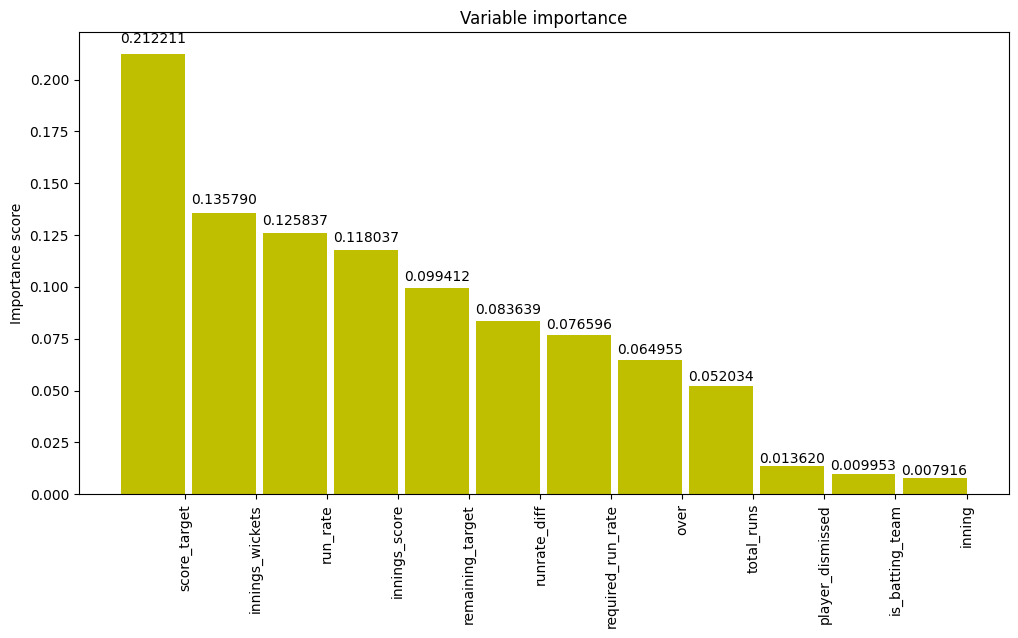

In [232]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()


create_feature_map(x_cols)
importance = model.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(),
                    key=operator.itemgetter(1), reverse=True)
imp_df = pd.DataFrame(importance, columns=['feature', 'fscore'])
imp_df['fscore'] = imp_df['fscore'] / imp_df['fscore'].sum()

# create a function for labeling #


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                '%f' % float(height),
                ha='center', va='bottom')


labels = np.array(imp_df.feature.values)
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12, 6))
rects = ax.bar(ind, np.array(imp_df.fscore.values), width=width, color='y')
ax.set_xticks(ind+((width)/2.))
ax.set_xticklabels(labels, rotation='vertical')
ax.set_ylabel("Importance score")
ax.set_title("Variable importance")
autolabel(rects)
plt.show()

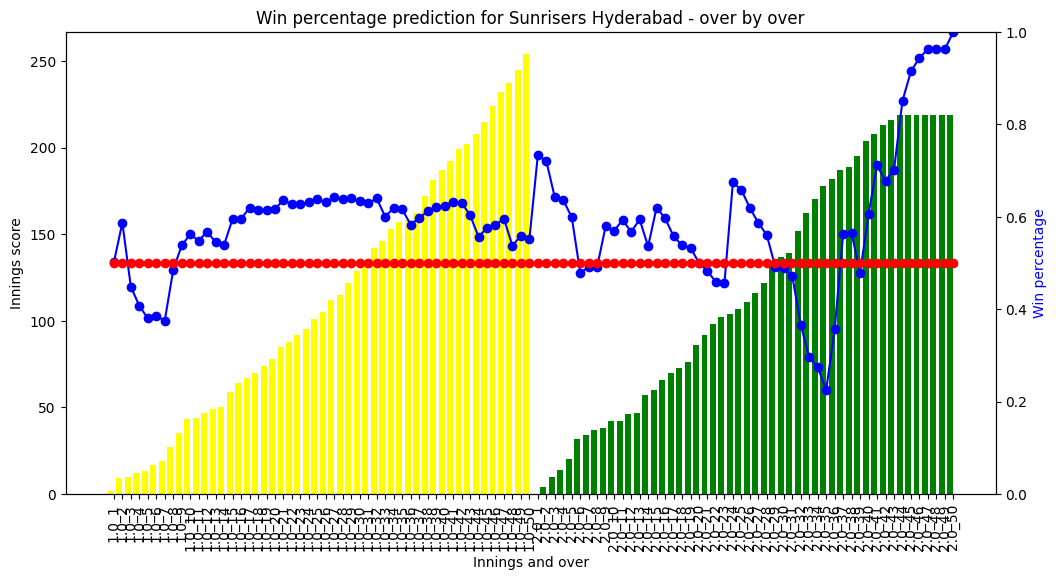

In [233]:
out_df = pd.DataFrame({'Team1': val_df.team1.values})
out_df['is_batting_team'] = val_df.is_batting_team.values
out_df['innings_over'] = np.array(val_df.apply(
    lambda row: str(row['inning']) + "_" + str(row['over']), axis=1))
out_df['innings_score'] = val_df.innings_score.values
out_df['innings_wickets'] = val_df.innings_wickets.values
out_df['score_target'] = val_df.score_target.values
out_df['total_runs'] = val_df.total_runs.values
out_df['predictions'] = list(preds)+[1]

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
labels = np.array(out_df['innings_over'])
ind = np.arange(len(labels))
width = 0.7
rects = ax1.bar(ind, np.array(out_df['innings_score']), width=width, color=[
                'yellow']*50 + ['green']*50)
ax1.set_xticks(ind+((width)/2.))
ax1.set_xticklabels(labels, rotation='vertical')
ax1.set_ylabel("Innings score")
ax1.set_xlabel("Innings and over")
ax1.set_title(
    "Win percentage prediction for Sunrisers Hyderabad - over by over")

ax2.plot(ind+0.35, np.array(out_df['predictions']), color='b', marker='o')
ax2.plot(ind+0.35, np.array([0.5]*100), color='red', marker='o')
ax2.set_ylabel("Win percentage", color='b')
ax2.set_ylim([0, 1])
ax2.grid(False)
plt.show()

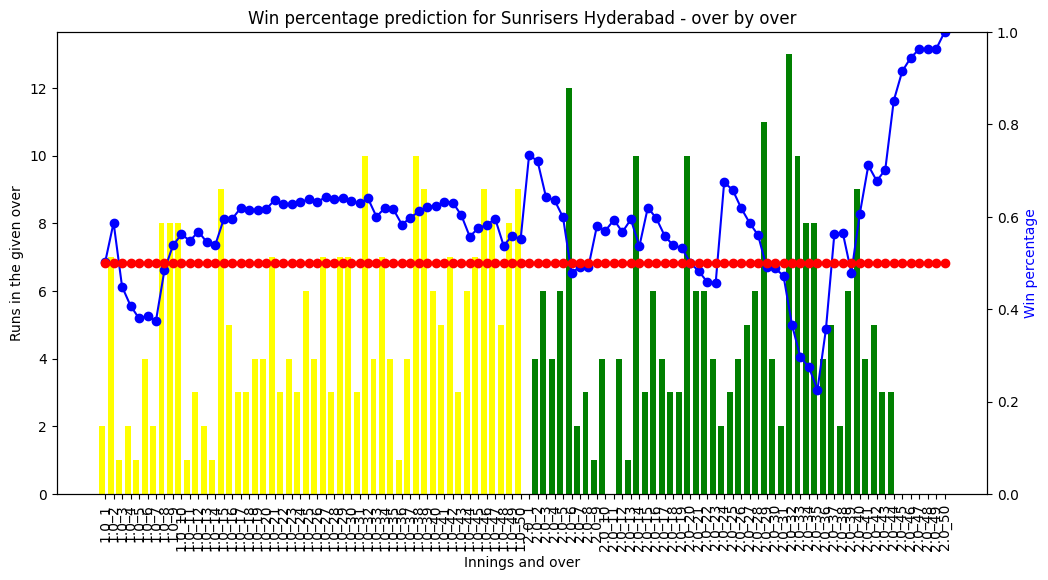

In [234]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
labels = np.array(out_df['innings_over'])
ind = np.arange(len(labels))
width = 0.7
rects = ax1.bar(ind, np.array(out_df['total_runs']), width=width, color=[
                'yellow']*50 + ['green']*50)
ax1.set_xticks(ind+((width)/2.))
ax1.set_xticklabels(labels, rotation='vertical')
ax1.set_ylabel("Runs in the given over")
ax1.set_xlabel("Innings and over")
ax1.set_title(
    "Win percentage prediction for Sunrisers Hyderabad - over by over")

ax2.plot(ind+0.35, np.array(out_df['predictions']), color='b', marker='o')
ax2.plot(ind+0.35, np.array([0.5]*100), color='red', marker='o')
ax2.set_ylabel("Win percentage", color='b')
ax2.set_ylim([0, 1])
ax2.grid(False)
plt.show()